In [1]:
from ConicalSpeaker import *
%matplotlib inline

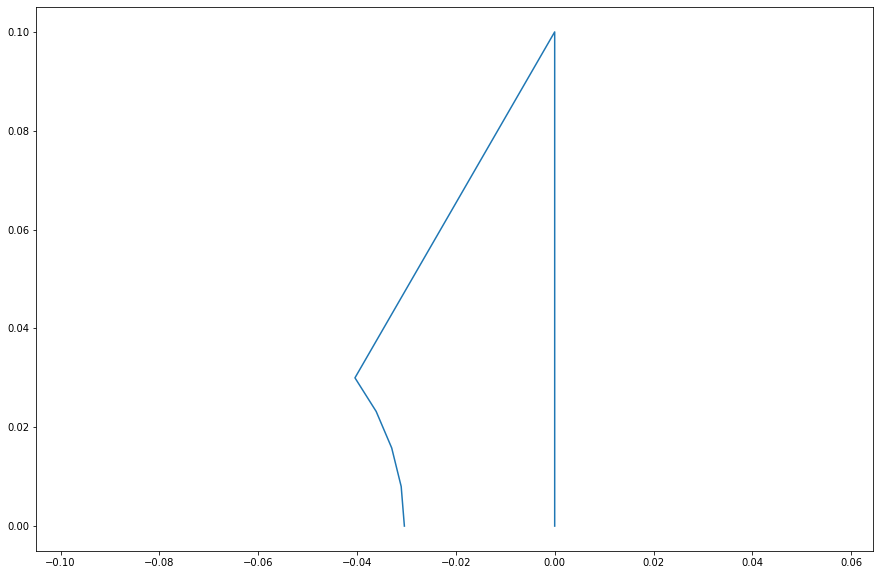

In [2]:
# 15 Inch ~ 38cm -> 19cm cone radius
# 30 degree cone angle
# 8cm dust cap -> 4cm dust cap radius
# 2cm dust cap height
s = ConicalSpeaker('8 inch Woofer', 0.10, 30.0, 0.03, 0.01)
s.plot_cone_section()

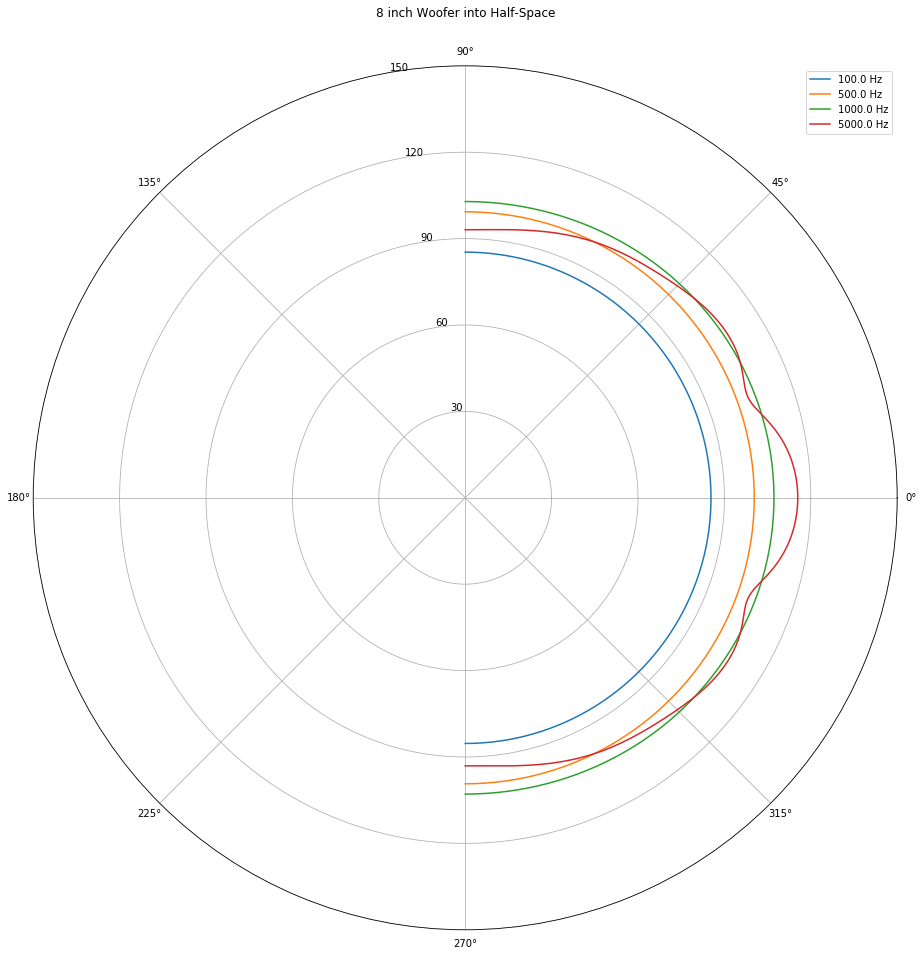

In [3]:
frequencies = np.array([100, 500, 1000, 5000], dtype=np.float32)
s.make_polar_plot(frequencies)

CPU times: user 1.51 s, sys: 34.1 ms, total: 1.55 s
Wall time: 4min 6s


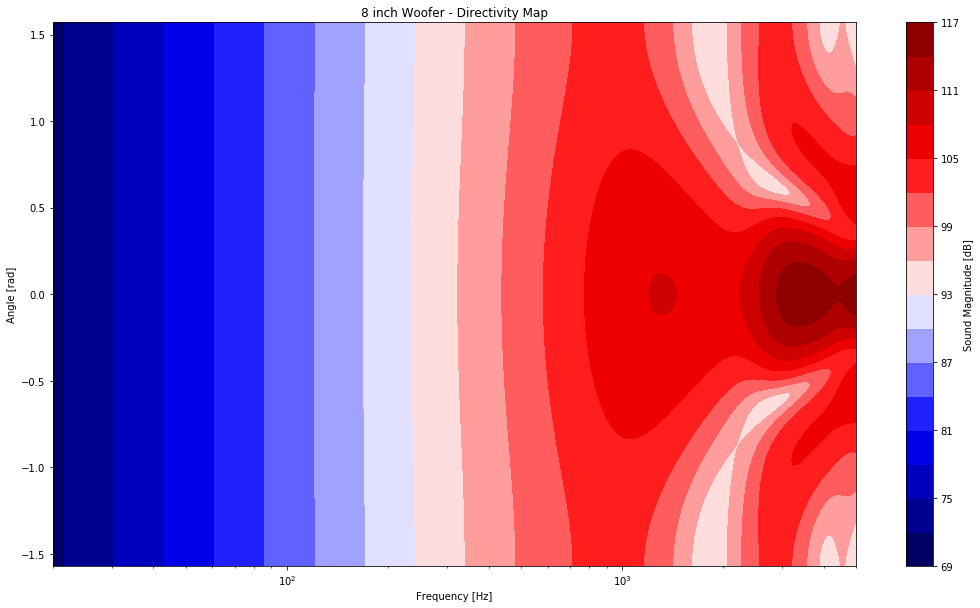

In [4]:
%%time
s.make_polar_map()

CPU times: user 1.34 s, sys: 47.6 ms, total: 1.39 s
Wall time: 2min 1s


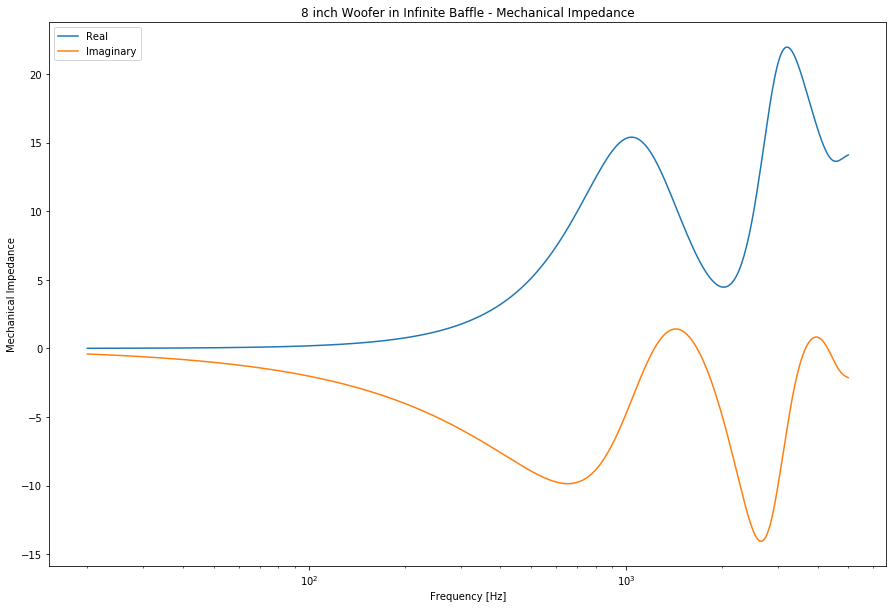

In [5]:
%%time
s.make_impedance_plot()